In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
ds = load_dataset("ylecun/mnist")

/Users/yuliagoryachev/miniconda3/envs/mlx_course/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [408]:
type(ds)

datasets.dataset_dict.DatasetDict

In [4]:
ds['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [24]:
#create a dataset where I have an encoder and I train it to predict the digit basic classifier but with a
#attention architecture, split the image into 4 parts (flatten each part and encode) and then use the attention to predict the digit

import torch
from torch import nn
from torch.utils.data import DataLoader
torch.manual_seed(123)


ds['train'][0]['image']

In [6]:
#matrix multiplication
import numpy as np

emb = np.array([[1,1,1], [2,2,2]])
emb = emb.reshape(1,2,3)
emb.shape

(1, 2, 3)

In [7]:
emb

array([[[1, 1, 1],
        [2, 2, 2]]])

In [8]:
weights = np.array([[1,2,3], [4,5,6], [7,8,9], [10,11,12]])


In [9]:
weights = weights.reshape(1, 3, 4)
weights.shape

(1, 3, 4)

In [10]:
weights

array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]]])

In [11]:
#dot produact emb * weights
np.matmul(emb, weights)

array([[[15, 18, 21, 24],
        [30, 36, 42, 48]]])

In [23]:
#positional encodings


import numpy as np

def positional_encoding(position: int, d_model: int):
    """
    position (int): Length of the sequence
    d_model (int): Dimensionality of the model's output
    """
 
    # Create a matrix of shape [position, d_model] where each element is the position index
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    
    # Apply sine to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cosine to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return pos_encoding.astype(np.float32)

# Example use
position = 50  # Length of the sequence
d_model = 512  # Dimensionality of the model's output
pos_encoding = positional_encoding(position, d_model)

print(pos_encoding.shape)  # Output the shape to verify the dimensions

(1, 50, 512)


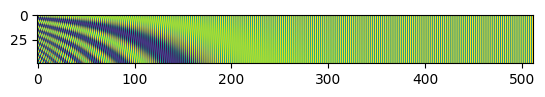

In [13]:
signal = np.ones((1, 50, 512))
res = signal+pos_encoding

plt.imshow(res[0])
plt.show()

In [14]:
np.array(ds['train'][0]['image']).shape

(28, 28)

In [171]:
#prepare the data
def prepare_data(data):
    #create 4 sequences out of each image
    data['image'] = torch.tensor(np.array(data['image']), dtype=torch.float32).view(4, 14, 14)
    #reshape the image to 4 sequences
    data['image'] = data['image'].reshape(4, 14*14)
    #normalize the image
    data['image'] = data['image'] / 255
    return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)

tens, label = prepare_data(ds['train'][0])

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [172]:
tens.shape

torch.Size([4, 196])

In [173]:
label

tensor(5)

In [174]:
ds.keys()

dict_keys(['train', 'test'])

In [175]:
#prepare dataloader that splits the image into 4 parts
from torch.utils.data import Dataset, DataLoader
class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return prepare_data(self.data[idx])
    
    def collate_fn(batch):
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.stack(labels)
        return images, labels

train_dataset = ImageDataset(ds['train'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ImageDataset.collate_fn)

test_dataset = ImageDataset(ds['test'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=ImageDataset.collate_fn)


In [176]:
print('n batches: ', len(train_loader))
print('n batches: ', len(test_loader))

n batches:  1875
n batches:  313


In [177]:
embed = torch.nn.Embedding(196, 94)

In [178]:
embed = torch.nn.Embedding(6, 16)
samp = torch.tensor([0, 4, 5, 2, 1, 3])
print(samp.shape)
embedded_sentence = embed(samp).detach()

torch.Size([6])


In [179]:
embed = torch.nn.Embedding(196, 16)
embed = torch.nn.Linear(196, 16)
for i, l in train_loader:
    # print(i.shape)
    # print(i[0].shape)
    samp = i[0].float()
    # samp = i[0].long()
    break

samp = torch.tensor(samp[0])
embedded_sentence = embed(samp)
print(embedded_sentence)

tensor([-0.0406, -0.0607,  0.0800,  0.1172, -0.1209, -0.0740,  0.2247, -0.0128,
         0.0260,  0.1123,  0.0910, -0.1045,  0.0583, -0.0094, -0.0261,  0.0165],
       grad_fn=<ViewBackward0>)


/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)
/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/1411750335.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samp = torch.tensor(samp[0])


In [180]:
samp.shape

torch.Size([196])

In [181]:
embedded_sentence.shape

torch.Size([16])

In [190]:
class ScaledDotProduct(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProduct, self).__init__()
        self.d_k = d_k # the size of the key and query vectors


    def forward(self, query, key, value):
        scores = query.matmul(key.transpose(-2, -1)) / np.sqrt(self.d_k)
        attention = torch.nn.functional.softmax(scores, dim=-1)
        output = torch.matmul(attention, value)
        return output, attention
    

class SelfAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.W_query = nn.Linear(d_model, d_k)
        self.W_key = nn.Linear(d_model, d_k)
        self.W_value = nn.Linear(d_model, d_v)
        self.attention = ScaledDotProduct(d_k)

    def forward(self, x):
        query = self.W_query(x)
        key = self.W_key(x)
        value = self.W_value(x)
        output, attention = self.attention(query, key, value)
        return output, attention
    

class TransformerImage(nn.Module):
    def __init__(self, d_seq, d_image, d_model, d_k, d_v, d_classes):
        """d_mode=d_embedding, d_image=14x14
        d_seq = 4"""
        super(TransformerImage, self).__init__()
        ''''''
        self.embedding = nn.Linear(d_image, d_model)
        #define positional encoding
        self.positional_encoding = positional_encoding(d_seq, d_model)
        self.attention = SelfAttention(d_model, d_k, d_v)
        self.linear1 = nn.Linear(d_model, d_classes)
        self.linear2 = nn.Linear(d_classes, d_classes)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        # print('emb: ', x.shape)
        #convert positional encoding to torch before adding
        self.positional_encoding = torch.tensor(self.positional_encoding)
        x = x + self.positional_encoding
        # print('position: ', x.shape)
        x, _ = self.attention(x)
        # print('attention: ', x.shape)
        #reshape x to be able to pass it to the linear layer
        x = x.view(x.shape[0], -1)
        # print('reshape: ', x.shape)
        x = self.linear1(x)
        self.relu(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


In [191]:
n_head = 4#number of heads
d_sample = 196#size of the sample
d_embedding = 128#size of the embedding
d_v = d_embedding//n_head#size of the value
d_q = d_embedding//n_head#size of the value
d_k = d_embedding//n_head#size of the value

In [192]:
model = TransformerImage(4, 196, d_embedding, d_k, d_v, 10)

In [193]:
#input a single sample into the model
for i, l in train_loader:
    # print(i.shape)
    # print(model(i[0]))
    break

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [194]:
i.shape

torch.Size([32, 4, 196])

In [195]:
model(i)

tensor([[0.0742, 0.1240, 0.0533, 0.1357, 0.1189, 0.0818, 0.0867, 0.1101, 0.1237,
         0.0915],
        [0.0754, 0.1272, 0.0517, 0.1381, 0.1168, 0.0807, 0.0866, 0.1095, 0.1236,
         0.0903],
        [0.0727, 0.1222, 0.0530, 0.1377, 0.1157, 0.0803, 0.0886, 0.1111, 0.1268,
         0.0920],
        [0.0726, 0.1235, 0.0513, 0.1381, 0.1162, 0.0815, 0.0871, 0.1142, 0.1231,
         0.0924],
        [0.0755, 0.1247, 0.0526, 0.1342, 0.1164, 0.0815, 0.0856, 0.1135, 0.1239,
         0.0921],
        [0.0737, 0.1227, 0.0536, 0.1340, 0.1182, 0.0809, 0.0873, 0.1112, 0.1255,
         0.0928],
        [0.0746, 0.1244, 0.0533, 0.1361, 0.1182, 0.0799, 0.0874, 0.1112, 0.1230,
         0.0918],
        [0.0749, 0.1260, 0.0524, 0.1372, 0.1182, 0.0804, 0.0868, 0.1111, 0.1223,
         0.0908],
        [0.0751, 0.1250, 0.0525, 0.1336, 0.1170, 0.0818, 0.0856, 0.1131, 0.1239,
         0.0923],
        [0.0743, 0.1223, 0.0537, 0.1339, 0.1172, 0.0815, 0.0867, 0.1111, 0.1263,
         0.0930],
        [0

In [196]:
#now lets train with the loaded data
import torch.optim as optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train(model, train_loader, loss_fn, optimizer, n_epochs):
    for epoch in range(n_epochs):
        model.train()
        for i, l in train_loader:
            optimizer.zero_grad()
            output = model(i)
            loss = loss_fn(output, l)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

train(model, train_loader, loss_fn, optimizer, 10)

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)
/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/2720785057.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.positional_encoding = torch.tensor(self.positional_encoding)


Epoch 1/10, Loss: 1.5878702402114868
Epoch 2/10, Loss: 1.714599609375
Epoch 3/10, Loss: 1.7182507514953613
Epoch 4/10, Loss: 1.6769814491271973
Epoch 5/10, Loss: 1.727035641670227
Epoch 6/10, Loss: 1.6831886768341064
Epoch 7/10, Loss: 1.7964287996292114


KeyboardInterrupt: 

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class AttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        """
        Args:
            input_dim (int): Dimension of each input vector.
            hidden_dim (int): Dimension of the projected query, key, and value.
            num_classes (int): Number of output classes.
        """
        super(AttentionClassifier, self).__init__()
        
        # Linear projections to obtain queries, keys, and values.
        self.linear_q = nn.Linear(input_dim, hidden_dim)
        self.linear_k = nn.Linear(input_dim, hidden_dim)
        self.linear_v = nn.Linear(input_dim, hidden_dim)
        
        # Scaling factor for dot-product attention.
        self.scale = math.sqrt(hidden_dim)
        
        # A classifier that takes the aggregated context vector as input.
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_vectors, input_dim).
                For example, if you have a list of vectors per sample.
        
        Returns:
            logits (torch.Tensor): Class scores of shape (batch_size, num_classes).
            attn_weights (torch.Tensor): Attention weights of shape (batch_size, num_vectors, num_vectors).
        """
        # Compute queries, keys, and values.
        # Shape: (batch_size, num_vectors, hidden_dim)
        Q = self.linear_q(x)
        K = self.linear_k(x)
        V = self.linear_v(x)
        
        # Compute scaled dot-product attention scores.
        # scores shape: (batch_size, num_vectors, num_vectors)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        
        # Compute attention weights using softmax.
        attn_weights = F.softmax(scores, dim=-1)
        
        # Compute the context vectors as a weighted sum of values.
        # context shape: (batch_size, num_vectors, hidden_dim)
        context = torch.matmul(attn_weights, V)
        
        # Aggregate the context vectors into a single representation per sample.
        # Here, we use mean pooling over the "num_vectors" dimension.
        # aggregated_context shape: (batch_size, hidden_dim)
        aggregated_context = context.mean(dim=1)
        print(aggregated_context.shape)
        # Pass the aggregated context to the classifier to get class scores.
        logits = self.classifier(aggregated_context)
        
        return logits, attn_weights

# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Hyperparameters
    batch_size = 4
    num_vectors = 10   # e.g., each sample consists of 10 vectors
    input_dim = 128    # dimension of each input vector
    hidden_dim = 64    # dimension of the projected Q, K, V vectors
    num_classes = 3    # e.g., a 3-class classification problem

    # Create a dummy batch of samples.
    # Each sample is represented as a set of 'num_vectors' vectors of dimension 'input_dim'.
    dummy_input = torch.rand(batch_size, num_vectors, input_dim)
    
    # Instantiate the attention-based classifier.
    model = AttentionClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    
    # Forward pass through the model.
    logits, attn_weights = model(dummy_input)
    
    print("Logits shape:", logits.shape)               # Expected: (batch_size, num_classes)
    print("Attention weights shape:", attn_weights.shape)  # Expected: (batch_size, num_vectors, num_vectors)


torch.Size([4, 64])
Logits shape: torch.Size([4, 3])
Attention weights shape: torch.Size([4, 10, 10])


In [206]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Positional Encoding module using the sinusoidal formulation
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model (int): The dimensionality of the embeddings.
            max_len (int): Maximum length of the sequence to be encoded.
        """
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, d_model) with positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, d_model)
        Returns:
            torch.Tensor: The input with positional encodings added.
        """
        # x.shape[1] is the sequence length
        x = x + self.pe[:, :x.size(1)]
        return x

# Attention-based classifier with positional encoding
class AttentionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, max_len=5000):
        """
        Args:
            input_dim (int): Dimensionality of each input vector.
            hidden_dim (int): Dimensionality for the projections (queries, keys, values).
            num_classes (int): Number of classes for classification.
            max_len (int): Maximum sequence length for positional encoding.
        """
        super(AttentionClassifier, self).__init__()
        # Positional encoding added to the input vectors
        self.pos_enc = PositionalEncoding(d_model=input_dim, max_len=max_len)
        
        # Linear layers to project the input into queries, keys, and values
        self.linear_q = nn.Linear(input_dim, hidden_dim)
        self.linear_k = nn.Linear(input_dim, hidden_dim)
        self.linear_v = nn.Linear(input_dim, hidden_dim)
        
        # Scaling factor for dot-product attention
        self.scale = math.sqrt(hidden_dim)
        
        # Final classifier layer
        self.classifier = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_vectors, input_dim).
        Returns:
            logits (torch.Tensor): Class scores of shape (batch_size, num_classes).
            attn_weights (torch.Tensor): Attention weights of shape (batch_size, num_vectors, num_vectors).
        """
        # Add positional encoding to the input vectors
        x = self.pos_enc(x)
        
        # Compute queries, keys, and values
        Q = self.linear_q(x)  # (batch_size, num_vectors, hidden_dim)
        K = self.linear_k(x)  # (batch_size, num_vectors, hidden_dim)
        V = self.linear_v(x)  # (batch_size, num_vectors, hidden_dim)
        
        # Compute scaled dot-product attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (batch_size, num_vectors, num_vectors)
        attn_weights = F.softmax(scores, dim=-1)
        
        # Compute the context vector as the weighted sum of values
        context = torch.matmul(attn_weights, V)  # (batch_size, num_vectors, hidden_dim)
        
        # Aggregate context across the sequence dimension (here, using mean pooling)
        aggregated_context = context.mean(dim=1)  # (batch_size, hidden_dim)
        
        # Compute logits for classification
        logits = self.classifier(aggregated_context)  # (batch_size, num_classes)
        
        return logits, attn_weights

# ------------------------------
# Example Usage
# ------------------------------
if __name__ == "__main__":
    # Define hyperparameters
    batch_size = 32
    num_vectors = 4   # Number of vectors per sample (sequence length)
    input_dim = 196    # Dimension of each input vector (and used for positional encoding)
    hidden_dim = 64    # Dimension used in the attention projections
    num_classes = 10    # Number of target classes

    # Create a dummy batch of input vectors
    dummy_input = torch.rand(batch_size, num_vectors, input_dim)
    
    # Instantiate the attention-based classifier
    model = AttentionClassifier(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
    
    # Forward pass
    logits, attn_weights = model(dummy_input)
    
    print("Logits shape:", logits.shape)               # Expected: (batch_size, num_classes)
    print("Attention weights shape:", attn_weights.shape)  # Expected: (batch_size, num_vectors, num_vectors)


Logits shape: torch.Size([32, 10])
Attention weights shape: torch.Size([32, 4, 4])


In [207]:
#train loop for the model
n_epochs=30
for epoch in range(n_epochs):
        model.train()
        for i, l in train_loader:
            optimizer.zero_grad()
            logits, attn_weights = model(i)
            # print(logits.shape)
            # print(l.shape)
            loss = loss_fn(logits, l)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


Epoch 1/30, Loss: 2.310288190841675
Epoch 2/30, Loss: 2.2883267402648926
Epoch 3/30, Loss: 2.3160266876220703
Epoch 4/30, Loss: 2.3050808906555176
Epoch 5/30, Loss: 2.3058316707611084
Epoch 6/30, Loss: 2.3214104175567627
Epoch 7/30, Loss: 2.3514609336853027
Epoch 8/30, Loss: 2.3604373931884766
Epoch 9/30, Loss: 2.3404479026794434
Epoch 10/30, Loss: 2.3558919429779053
Epoch 11/30, Loss: 2.3757410049438477
Epoch 12/30, Loss: 2.264167547225952
Epoch 13/30, Loss: 2.3080880641937256
Epoch 14/30, Loss: 2.4039061069488525
Epoch 15/30, Loss: 2.2709598541259766
Epoch 16/30, Loss: 2.2068135738372803
Epoch 17/30, Loss: 2.3869380950927734
Epoch 18/30, Loss: 2.3030245304107666
Epoch 19/30, Loss: 2.3571088314056396
Epoch 20/30, Loss: 2.3620195388793945


KeyboardInterrupt: 

--------

-------

In [537]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Args:
            d_model (int): Dimensionality of the model (embedding size).
            max_len (int): Maximum length of input sequences.
        """
        super(PositionalEncoding, self).__init__()
        # Create a long enough 'pe' matrix with shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # Apply sin to even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Apply cos to odd indices
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x (Tensor): Input of shape (batch_size, seq_len, d_model)
        Returns:
            Tensor: x plus positional encodings.
        """
        print('before encoding:', x.shape)
        print('pe shape:', self.pe[:, :x.size(1)].shape)
        x = x + self.pe[:, :x.size(1)]
        return x

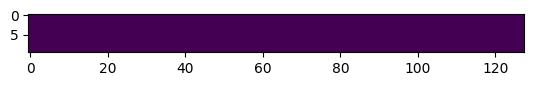

before encoding: torch.Size([4, 10, 128])
pe shape: torch.Size([1, 10, 128])
torch.Size([4, 10, 128])


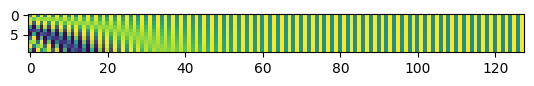

In [538]:
p = PositionalEncoding(128)
x = torch.ones(4, 10, 128)
plt.imshow(x[0].detach().numpy())
plt.show()
x = p(x)
print(x.shape)  # Expected: (4, 10, 128)
plt.imshow(x[0].detach().numpy())
plt.show()

In [539]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        """
        Args:
            d_model (int): Model dimension.
            num_heads (int): Number of attention heads.
            dropout (float): Dropout probability.
        """
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head
        print('self.d_k: ', self.d_k)
        # Linear projections for queries, keys, and values.
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        
        # Final linear layer after concatenating heads.
        self.linear_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        """
        Args:
            query, key, value (Tensor): Each of shape (batch_size, seq_len, d_model).
            mask (Tensor, optional): Mask tensor broadcastable to (batch_size, num_heads, seq_len, seq_len).
        Returns:
            output (Tensor): Attention output of shape (batch_size, seq_len, d_model).
            attn (Tensor): Attention weights of shape (batch_size, num_heads, seq_len, seq_len).
        """
        batch_size = query.size(0)
        
        # Linear projections and reshape into (batch_size, num_heads, seq_len, d_k)
        print('attention shapes:')
        print('original shape: ', self.linear_q(query).shape)
        print(self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).shape)
        Q = self.linear_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('shape after multihead preparation: ', Q.shape)
        K = self.linear_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('K: ', K.shape)
        V = self.linear_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        print('V :', V.shape)
        
        # Compute scaled dot-product attention.
        # scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        print('scores shape: ', scores.shape)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # Compute weighted sum of values.
        # context: (batch_size, num_heads, seq_len, d_k)
        context = torch.matmul(attn, V)
        print('context shape: ', context.shape)
        # Concatenate heads and put through final linear layer.
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.linear_out(context)
        return output, attn

In [339]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        """
        Args:
            d_model (int): Model dimension.
            num_heads (int): Number of attention heads.
            d_hidden (int): Dimension of the feed-forward network.
            dropout (float): Dropout probability.
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        
        # Position-wise feed-forward network.
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        # Multi-head self-attention sublayer with residual connection.
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.layernorm1(x + self.dropout1(attn_output))
        
        # Feed-forward sublayer with residual connection.
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))
        return x, attn_weights


In [340]:
class TransformerEncoder(nn.Module):
    def __init__(self, image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_categories, dropout=0.1):
        """
        Args:
            vocab_size (int): Vocabulary size.
            d_model (int): Model dimension.
            num_layers (int): Number of encoder layers.
            num_heads (int): Number of attention heads.
            d_ff (int): Feed-forward dimension.
            max_seq_len (int): Maximum sequence length.
            dropout (float): Dropout probability.
        """
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(image_size*image_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=max_seq_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.linear = nn.Linear(d_model, n_categories)
    
    def forward(self, src, mask=None):
        """
        Args:
            src (Tensor): Input tensor of token indices with shape (batch_size, seq_len).
            mask (Tensor, optional): Attention mask.
        Returns:
            x (Tensor): Encoder output of shape (batch_size, seq_len, d_model).
            all_attn (list): List of attention weight tensors from each layer.
        """
        x = self.embedding(src)
        print('embedding', x.shape)
        x = self.pos_enc(x)
        # print('pos', x.shape)
        x = self.dropout(x)
        all_attn = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            # print('layer', x.shape)
            # print('attn', attn.shape)
            all_attn.append(attn)
        # print('finished attention')
        pooled = torch.mean(x, dim=1)  # shape: (batch_size, d_model)
        # 6. Compute classification logits from the pooled representation.
        logits = self.linear(pooled)  # shape: (batch_size, num_classes)
        return logits

In [355]:
# ------------------------------
# 5. Example Usage
# ------------------------------
image_size = 14
d_model = 128
num_layers = 2
num_heads = 8
d_ff = 256
max_seq_len = 196
dropout = 0.1
n_digits = 10  # Number of output classes

# Create a dummy input tensor
batch_size = 32
dummy_input = torch.randint(0, 4*image_size*image_size, (batch_size, max_seq_len))
    
# Instantiate the transformer encoder
encoder = TransformerEncoder(image_size, d_model, num_layers, num_heads, d_ff, max_seq_len, n_digits, dropout)
    
# Forward pass
encoder

self.d_k:  16
self.d_k:  16


TransformerEncoder(
  (embedding): Linear(in_features=196, out_features=128, bias=True)
  (pos_enc): PositionalEncoding()
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (linear_q): Linear(in_features=128, out_features=128, bias=True)
        (linear_k): Linear(in_features=128, out_features=128, bias=True)
        (linear_v): Linear(in_features=128, out_features=128, bias=True)
        (linear_out): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (layernorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Linear(in_features=256, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (drop

In [360]:
#train loop with the training data
n_epochs=2
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001)
for epoch in range(n_epochs):
        encoder.train()
        for i, l in train_loader:
            # print(i.shape)
            # print(l.shape)
            optimizer.zero_grad()
            logits = encoder(i)
            loss = loss_fn(logits, l)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}')

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


embedding torch.Size([32, 4, 128])
before encoding: torch.Size([32, 4, 128])
pe shape: torch.Size([1, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
embedding torch.Size([32, 4, 128])
before encoding: torch.Size([32, 4, 128])
pe shape: torch.Size([1, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : t

In [361]:
for i, l in train_loader:
        print(i)
        print(l)
        break

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
     

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [362]:
#evaluate the model on the test data
def evaluate_model(model, test_loader):
    encoder.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, l in test_loader:
            outputs = model(i)
            _, predicted = torch.max(outputs.data, 1)
            print('predicted ', predicted)
            print('l', l)
            total += l.size(0)
            correct += (predicted == l).sum().item()
    return correct / total


In [363]:
evaluate_model(encoder, test_loader)

/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/596500830.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


embedding torch.Size([32, 4, 128])
before encoding: torch.Size([32, 4, 128])
pe shape: torch.Size([1, 4, 128])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
attention shapes:
original shape:  torch.Size([32, 4, 128])
torch.Size([32, 4, 8, 16])
shape after multihead preparation:  torch.Size([32, 8, 4, 16])
K:  torch.Size([32, 8, 4, 16])
V : torch.Size([32, 8, 4, 16])
scores shape:  torch.Size([32, 8, 4, 4])
context shape:  torch.Size([32, 8, 4, 16])
predicted  tensor([8, 1, 9, 0, 6, 2, 1, 4, 3, 8, 8, 8, 9, 3, 3, 7, 0, 7, 7, 2, 1, 4, 2, 6,
        2, 0, 8, 8, 1, 3, 0, 2])
l tensor([8, 1, 9, 0, 6, 2, 1, 4, 3, 8, 8, 8, 9, 3, 3, 7, 0, 7, 7, 2, 1, 4, 2, 6,
        2, 0, 3, 8, 1, 3, 0, 2])
embedding torch.Size([32, 4, 128])
before encoding: torch.

0.9645

# Data perparartion

In [395]:
# (image, caption-input, caption-label) 
# recombine 4 images into 1 and 4 labels into 1
def recombine_data(data):
    dicty = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
    "data is a batch of images and labels"
    img = np.array(data['image'][0])
    img_shape = img.shape
    big_image = np.ndarray([img_shape[0]*2, img_shape[1]*2])
    big_image[0:img_shape[0], 0:img_shape[1]] = data['image'][0]
    big_image[0:img_shape[0], img_shape[1]:2*img_shape[1]] = data['image'][1]
    big_image[img_shape[0]:2*img_shape[0], 0:img_shape[1]] = data['image'][2]
    big_image[img_shape[0]:2*img_shape[0], img_shape[1]:2*img_shape[1]] = data['image'][3]
    label = ' '.join([dicty[i] for i in data['label']])
    return big_image, label

In [398]:
recomb_image, label = recombine_data(ds['train'][:4])

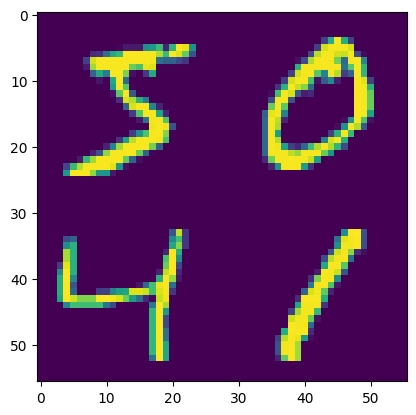

In [399]:
plt.imshow(recomb_image)
plt.show()

In [400]:
label

'five zero four one'

In [524]:
def recombine_data(data):
    # dicty = {0: 'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven', 8: 'eight', 9: 'nine'}
    "data is a batch of images and labels"
    img = np.array(data[0]['image'])
    img_shape = img.shape
    big_image = np.ndarray([img_shape[0]*2, img_shape[1]*2])
    big_image[0:img_shape[0], 0:img_shape[1]] = data[0]['image']
    big_image[0:img_shape[0], img_shape[1]:2*img_shape[1]] = data[1]['image']
    big_image[img_shape[0]:2*img_shape[0], 0:img_shape[1]] = data[2]['image']
    big_image[img_shape[0]:2*img_shape[0], img_shape[1]:2*img_shape[1]] = data[3]['image']
    label = [i['label'] for i in data]
    return big_image, label

In [525]:
#apply the recombine transformation to the dataset
#create dataset dict in pytorch
from torch.utils.data import Dataset
import datasets
from tqdm import tqdm
import random


train = [i for i in ds['train']]
test = [i for i in ds['test']]

new_train = []
new_test = []
for i in tqdm(range(0, len(train), 4)):
    img, label = recombine_data(train[i:i+4])
    new_train.append({'image': img, 'label': label})

for i in tqdm(range(0, len(test), 4)):
    img, label = recombine_data(test[i:i+4])
    new_test.append({'image': img, 'label': label})

# shuffle ds['train'] and repeat to create more images
# shuffle the dataset
random.shuffle(train)
for i in tqdm(range(0, len(train), 4)):
    img, label = recombine_data(train[i:i+4])
    new_train.append({'image': img, 'label': label})

# shuffle the dataset
random.shuffle(test)
for i in tqdm(range(0, len(test), 4)):
    img, label = recombine_data(test[i:i+4])
    new_test.append({'image': img, 'label': label})

100%|██████████| 2500/2500 [00:00<00:00, 47113.04it/s]


In [526]:
ds_new = datasets.DatasetDict({"train":new_train, "test":new_test})

[7, 2, 1, 0]


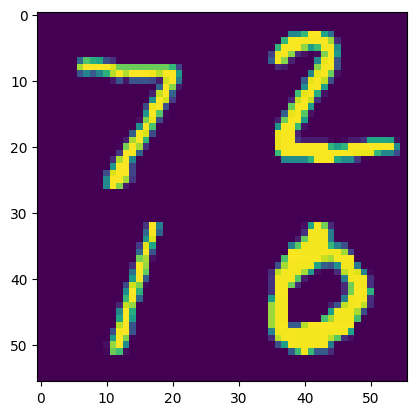

In [527]:
for i in ds_new['test']:
    print(i['label'])
    plt.imshow(i['image'])
    plt.show()
    break


In [528]:
print(len(ds_new['train']), len(ds_new['test']))

30000 5000


In [529]:
ds_new['train'][0]

{'image': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'label': [5, 0, 4, 1]}

In [530]:
ds_new['train'][0]['image'].shape

(56, 56)

In [535]:
#prepare the dataloader for the new dataset, broadcast the labels for each patch
def prepare_data(data):
    #create 16 sequences out of each image
    data['image'] = torch.tensor(np.array(data['image']), dtype=torch.float32).view(16, 14, 14)
    #reshape the image to 16 sequences
    data['image'] = data['image'].reshape(16, 14*14)
    #normalize the image
    data['image'] = data['image'] / 255
    #data['label'] keep as numbers so no tokenizer is needed
    return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return prepare_data(self.data[idx])
    
    def collate_fn(batch):
        images, labels = zip(*batch)
        print('iamges: ', images)
        print('labels: ', labels)
        images = torch.stack(images)
        labels = torch.stack(labels)
        return images, labels
    
train_dataset = ImageDataset(ds_new['train'])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=ImageDataset.collate_fn)
test_dataset = ImageDataset(ds_new['test'])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=ImageDataset.collate_fn)

In [536]:
for i, l in test_loader:
    print(i.shape)
    print(l.shape)
    break

iamges:  (tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]),)
labels:  (tensor([5, 9, 2, 8]),)
torch.Size([1, 16, 196])
torch.Size([1, 4])


/var/folders/7k/nmbh9fxj4dsbx6d3jx2k1lvm0000gn/T/ipykernel_6727/3338502556.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data['image'], dtype=torch.float32), torch.tensor(data['label'], dtype=torch.long)


In [ ]:
#make the deocder